# Importation des bibliothèques

In [11]:
import re
import time
import kagglehub
import keras
import matplotlib.pyplot as plt
import numpy as np
import keras_hub
import keras_tuner
import pandas as pd
import pkuseg
import tensorflow as tf
from datasets import Dataset
from pypinyin import lazy_pinyin
from keras.layers import (
    LSTM,
    Dense,
    Embedding,
    Input,
    Dropout,
    Concatenate,
    Attention,
    StringLookup,
    TextVectorization,
)
from keras.models import Model

# Vérifier GPU
print(tf.config.list_physical_devices('GPU'))
# tf.debugging.set_log_device_placement(True)

seg = pkuseg.pkuseg()
path = kagglehub.dataset_download("noxmoon/chinese-official-daily-news-since-2016")

print("\nPath to dataset files:", path)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Path to dataset files: /Users/petx/.cache/kagglehub/datasets/noxmoon/chinese-official-daily-news-since-2016/versions/1


# Création du corpus

In [12]:
dataset = pd.read_csv(path+"/chinese_news.csv")
# Print dataset information
print("Dataset information:")
print(dataset.info())
# Print dataset head
print("Dataset head:")
print(dataset.head())

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20738 entries, 0 to 20737
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      20738 non-null  object
 1   tag       20738 non-null  object
 2   headline  20738 non-null  object
 3   content   20631 non-null  object
dtypes: object(4)
memory usage: 648.2+ KB
None
Dataset head:
         date   tag                                           headline  \
0  2016-01-01  详细全文  陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...   
1  2016-01-01  详细全文                             中央军委印发《关于深化国防和军队改革的意见》   
2  2016-01-01  详细全文                           《习近平关于严明党的纪律和规矩论述摘编》出版发行   
3  2016-01-01  详细全文                                 以实际行动向党中央看齐 向高标准努力   
4  2016-01-01  详细全文                                 【年终特稿】关键之年 改革挺进深水区   

                                             content  
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...  
1  经中央军委主席习近平批准，中央军委近日印发了《关

In [13]:
# Prétraitement de content (suppression des caractères non chinois, normalisation des espaces)
def clean_content(text):
    if not isinstance(text, str):
        return ""
    
    # Garder les caractères chinois et ponctuation chinoise
    text = re.sub(r"[^\u4e00-\u9fff\u3000-\u303F\uff00-\uffef]", "", text)
    
    # Normaliser les espaces (rare, mais au cas où)
    text = text.replace(" ", "").strip()

    return text

# Remplacer les valeurs manquantes par une chaîne vide
dataset["content"] = dataset["content"].fillna("")

# Appliquer le prétraitement à la colonne 'content'
dataset['cleaned_content'] = dataset['content'].apply(clean_content)

# Filtrer les lignes où 'cleaned_content' est vide
dataset = dataset[dataset["cleaned_content"].str.strip() != ""].reset_index(drop=True)

# Afficher les 5 premières lignes du DataFrame après le prétraitement
print("Dataset after preprocessing:")
print(dataset[['content', 'cleaned_content']].head())


dataset["tokens"] = dataset["cleaned_content"].apply(lambda x: seg.cut(x))

# Aperçu
print(dataset["tokens"].head())

Dataset after preprocessing:
                                             content  \
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...   
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...   
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...   
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...   
4  刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，...   

                                     cleaned_content  
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会年月日在...  
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。《意见》强调，...  
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...  
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...  
4  刚刚过去的年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，集中发力...  
0    [中国, 人民, 解放军, 陆军, 领导, 机构, 、, 中国, 人民, 解放军, 火箭军,...
1    [经, 中央军委, 主席, 习近平, 批准, ，, 中央军委, 近日, 印发, 了, 《, ...
2    [由, 中共中央, 纪律, 检查, 委员会, 、, 中共中央, 文献, 研究室, 编辑, 的...
3    [广大, 党员, 干部, 正在, 积极, 学习, 习近平, 总书记, 在, 中央, 政治局,...
4    [刚刚, 过去, 的, 年, ，, 是, 全面, 深化, 改革, 的, 关键, 之, 年, ...
Name: tokens, dtype: object


In [14]:
# convert the content column to pinyin
t9_map = {
    "@": "1", ".": "1", ":": "1",
    "a": "2", "b": "2", "c": "2",
    "d": "3", "e": "3", "f": "3",
    "g": "4", "h": "4", "i": "4",
    "j": "5", "k": "5", "l": "5",
    "m": "6", "n": "6", "o": "6",
    "p": "7", "q": "7", "r": "7", "s": "7",
    "t": "8", "u": "8", "v": "8",
    "w": "9", "x": "9", "y": "9", "z": "9",
    "1": "1", "2": "2", "3": "3", "4": "4",
    "5": "5", "6": "6", "7": "7", "8": "8",
    "9": "9", "0": "0", " ": "0",
    "。":"。", "，":"，", "？":"？", "！":"！",
}

# Fonction pour convertir une chaîne de caractères en code T9
def pinyin_to_t9(text):
    t9_code = ""
    if pd.isna(text):
        return ""
    for char in text.lower():
        t9_code += t9_map.get(char, char)  # Conserver les caractères non mappés
    return t9_code

def validate_t9(t9_code):
    # Vérifie que le code T9 est numérique (ou vide pour ponctuation)
    return bool(re.match(r'^[0-9]+$', t9_code)) or t9_code in {"。", "，", "？", "！"}

def generer_sequence_contextuelle(row):
    tokens = row["tokens"]
    sequence = []
    for token in tokens:
        if not isinstance(token, str) or not re.search(r'[\u4e00-\u9fff]', token):
            continue
        for char, py in zip(token, lazy_pinyin(token)):
            t9 = pinyin_to_t9(py)
            if validate_t9(t9):  # Vérifier que le T9 est valide
                sequence.append(f"{char}|{py}|{t9}")
    return ' '.join(sequence)

dataset["char_pinyin_t9_sequence"] = dataset.apply(generer_sequence_contextuelle, axis=1)

# Filtrer les lignes où 'char_pinyin_t9_sequence' est vide
dataset = dataset[dataset["char_pinyin_t9_sequence"].str.strip() != ""].reset_index(drop=True)

# Sauvegarder le fichier
dataset[["char_pinyin_t9_sequence"]].to_csv("sequences_char_pinyin_t9.csv", index=False)

# Afficher les 5 premières lignes du DataFrame après le prétraitement
print("Dataset after generating sequences:")
print(dataset[['content', 'char_pinyin_t9_sequence']].head())

Dataset after generating sequences:
                                             content  \
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...   
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...   
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...   
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...   
4  刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，...   

                             char_pinyin_t9_sequence  
0  中|zhong|94664 国|guo|486 人|ren|736 民|min|646 解|...  
1  经|jing|5464 中|zhong|94664 央|yang|9264 军|jun|58...  
2  由|you|968 中|zhong|94664 共|gong|4664 中|zhong|94...  
3  广|guang|48264 大|da|32 党|dang|3264 员|yuan|9826 ...  
4  刚|gang|4264 刚|gang|4264 过|guo|486 去|qu|78 的|de...  


# Création du dataset pour le modèle

In [15]:
dataset = dataset[["char_pinyin_t9_sequence"]]


# Modifier la génération des séquences pour inclure le contexte
input_t9_sequences = []
context_char_sequences = []
target_char_sequences = []
MAX_CONTEXT_LENGTH = 10  # Longueur max du contexte
MAX_T9_LENGTH = 10      # Longueur max de la séquence T9
MAX_TARGET_LENGTH = 10  # Longueur max de la séquence cible

for seq in dataset["char_pinyin_t9_sequence"]:
    triplets = seq.strip().split(" ")
    t9_seq = []
    char_seq = []
    
    for triplet in triplets:
        parts = triplet.split("|")
        if len(parts) == 3:
            char, _, t9 = parts
            if validate_t9(t9):
                char_seq.append(char)
                t9_seq.append(t9)
    
    # Créer des paires contexte-T9-cible
    for i in range(1, len(t9_seq)):
        # Contexte : caractères avant la position i
        context = char_seq[:i][-MAX_CONTEXT_LENGTH:]
        # Entrée T9 : codes T9 à partir de i
        t9_input = t9_seq[i:i+MAX_T9_LENGTH]
        # Cible : caractères à partir de i
        target = char_seq[i:i+MAX_TARGET_LENGTH]
        
        if context and t9_input and target:
            context_char_sequences.append("".join(context))
            input_t9_sequences.append(" ".join(t9_input))
            target_char_sequences.append("".join(target))

# Créer un DataFrame
df_sequences = pd.DataFrame({
    "context_char_sequence": context_char_sequences,
    "input_t9_sequence": input_t9_sequences,
    "target_char_sequence": target_char_sequences
})

# Filtrer les séquences vides
df_sequences = df_sequences[
    (df_sequences["context_char_sequence"].str.strip() != "") &
    (df_sequences["input_t9_sequence"].str.strip() != "") &
    (df_sequences["target_char_sequence"].str.strip() != "")
]

In [16]:
print("DataFrame sequences:")
print(df_sequences.head())

DataFrame sequences:
  context_char_sequence                          input_t9_sequence  \
0                     中   486 736 646 543 3264 586 58 586 5464 326   
1                    中国    736 646 543 3264 586 58 586 5464 326 54   
2                   中国人    646 543 3264 586 58 586 5464 326 54 468   
3                  中国人民  543 3264 586 58 586 5464 326 54 468 94664   
4                 中国人民解  3264 586 58 586 5464 326 54 468 94664 486   

  target_char_sequence  
0           国人民解放军陆军领导  
1           人民解放军陆军领导机  
2           民解放军陆军领导机构  
3           解放军陆军领导机构中  
4           放军陆军领导机构中国  


In [17]:
tf_dataset = tf.data.Dataset.from_tensor_slices((
    df_sequences["context_char_sequence"].values,
    df_sequences["input_t9_sequence"].values,
    df_sequences["target_char_sequence"].values
)).batch(256).prefetch(tf.data.AUTOTUNE)

tf_dataset.take(1).get_single_element()

(<tf.Tensor: shape=(256,), dtype=string, numpy=
 array([b'\xe4\xb8\xad', b'\xe4\xb8\xad\xe5\x9b\xbd',
        b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba',
        b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91',
        b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3',
        b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe',
        b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b',
        b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86',
        b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86\xe5\x86\x9b',
        b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86\xe5\x86\x9b\xe9\xa2\x86',
        b'\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86\xe5\x86\x9b\xe9\xa2\x86\xe5\xaf\xbc',
        b'\xe4\xba\xba\xe6\xb0\x91\xe

## Encoder les données pour Keras

In [18]:
# TextVectorization pour le contexte, T9 et cible
context_tv = keras.layers.TextVectorization(
    output_mode='int',
    split='character',
    standardize=None,
    ragged=True
)

input_t9_tv = keras.layers.TextVectorization(
    output_mode='int',
    split='whitespace',
    standardize=None,
    ragged=True
)

target_tv = keras.layers.TextVectorization(
    output_mode='int',
    split='character',
    standardize=None,
    ragged=True
)


# Adapter les vectoriseurs
context_ds = tf_dataset.map(
    lambda context, t9, target: context,
    num_parallel_calls=tf.data.AUTOTUNE
)
t9_ds = tf_dataset.map(
    lambda context, t9, target: t9,
    num_parallel_calls=tf.data.AUTOTUNE
)
target_ds = tf_dataset.map(
    lambda context, t9, target: target,
    num_parallel_calls=tf.data.AUTOTUNE
)

# Adapter les TextVectorization layers
start = time.time()
context_tv.adapt(context_ds)
print(f"Adapt context_tv: {time.time() - start:.2f} seconds")

start = time.time()
input_t9_tv.adapt(t9_ds)
print(f"Adapt input_t9_tv: {time.time() - start:.2f} seconds")

start = time.time()
target_tv.adapt(target_ds)
# Ajouter <START> et <END> au vocabulaire
target_vocab = target_tv.get_vocabulary()
if "<START>" not in target_vocab or "<END>" not in target_vocab:
    updated_vocab = ["<START>", "<END>"] + [tok for tok in target_vocab if tok not in ["", "[UNK]"]]
    target_tv.set_vocabulary(updated_vocab)
print(f"Adapt target_tv: {time.time() - start:.2f} seconds")
print(f"Target vocab size: {target_tv.vocabulary_size()}")

# Vérification
vocab = target_tv.get_vocabulary()
print(f"<START> index: {vocab.index('<START>')}")
print(f"<END> index: {vocab.index('<END>')}")

Adapt context_tv: 75.70 seconds


2025-04-12 14:48:35.232272: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Adapt input_t9_tv: 100.41 seconds
Adapt target_tv: 69.65 seconds
Target vocab size: 4598
<START> index: 2
<END> index: 3


In [19]:
start_token_idx = target_tv.get_vocabulary().index("<START>")

# Transformer le dataset
@tf.function
def transform_ds(context, t9, target):
    # Vectoriser le contexte, T9 et cible 
    vectorized_context = context_tv(context).to_tensor(default_value=0) # default_value=0 => padding
    vectorized_t9 = input_t9_tv(t9).to_tensor(default_value=0)
    vectorized_target = target_tv(target).to_tensor(default_value=0)
    batch_size = tf.shape(vectorized_target)[0] # (1024,)
    # Créer le décalage pour le décodeur
    # On ajoute le token de début au début de la séquence cible et on décale la séquence cible
    start_token = tf.fill([batch_size, 1], tf.cast(start_token_idx, tf.int32)) # (1024, 1)
    # On concatène le token de début avec la séquence cible décalée
    decoder_in = tf.concat([start_token, tf.cast(vectorized_target[:, :-1], tf.int32)], axis=1) # (1024, 10)
    return (vectorized_context, vectorized_t9, decoder_in), vectorized_target

transformed_tf_dataset = tf_dataset.map(transform_ds)
for (context, t9, dec_in), target in transformed_tf_dataset.take(1):
    print(f"Context: {context}")
    print(f"T9: {t9}")
    print(f"Decoder input: {dec_in}")
    print(f"Target: {target}")

Context: [[  4   0   0 ...   0   0   0]
 [  4   3   0 ...   0   0   0]
 [  4   3   8 ...   0   0   0]
 ...
 [268  30  23 ...  86  65  48]
 [ 30  23  67 ...  65  48  33]
 [ 23  67  28 ...  48  33  83]]
T9: [[ 7 30 76 ... 54 24 25]
 [30 76 43 ... 24 25  3]
 [76 43 17 ... 25  3 86]
 ...
 [52 36 54 ...  8 31 54]
 [36 54 14 ... 31 54 14]
 [54 14 46 ... 54 14 24]]
Decoder input: [[   2    5   10 ...  673  103   87]
 [   2   10   23 ...  103   87  122]
 [   2   23  246 ...   87  122   92]
 ...
 [   2   37   85 ... 1053  774  673]
 [   2   85  103 ...  774  673  103]
 [   2  103  900 ...  673  103  504]]
Target: [[   5   10   23 ...  103   87  122]
 [  10   23  246 ...   87  122   92]
 [  23  246  255 ...  122   92  262]
 ...
 [  37   85  103 ...  774  673  103]
 [  85  103  900 ...  673  103  504]
 [ 103  900 1254 ...  103  504  808]]


In [20]:
transformed_tf_dataset.take(1).get_single_element()

# Shape du dataset
for (context, t9, dec_in), target in transformed_tf_dataset.take(1):
    print(f"Context shape: {context.shape}")
    print(f"T9 shape: {t9.shape}")
    print(f"Decoder input shape: {dec_in.shape}")
    print(f"Target shape: {target.shape}")

Context shape: (256, 10)
T9 shape: (256, 10)
Decoder input shape: (256, 10)
Target shape: (256, 10)


## Split train-valid-test

In [21]:
c = transformed_tf_dataset.reduce(0, lambda x, _: x + 1).numpy()
shuffled_ds = transformed_tf_dataset.shuffle(buffer_size=c, seed=42)

train_size = c * 80 // 100
test_size = c * 10 // 100
val_size = c - train_size - test_size

ds_train = shuffled_ds.take(train_size).prefetch(tf.data.AUTOTUNE)
ds_val = shuffled_ds.skip(train_size).take(val_size).prefetch(tf.data.AUTOTUNE)
ds_test = shuffled_ds.skip(train_size+val_size).take(test_size).prefetch(tf.data.AUTOTUNE)

print("Taille du train :", ds_train.cardinality().numpy())
print("Taille du validation :", ds_val.cardinality().numpy())
print("Taille du test :", ds_test.cardinality().numpy())

2025-04-12 14:49:45.760989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Taille du train : 18807
Taille du validation : 2352
Taille du test : 2350


In [22]:
# Visualisation des données
print("Exemple de données :")
for (context, t9, dec_in), target in ds_train.take(1):
    print(f"Context: {context[0]}")
    print(f"T9: {t9[0]}")
    print(f"Decoder input: {dec_in[0]}")
    print(f"Target: {target[0]}")

Exemple de données :


2025-04-12 14:50:15.498599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 12790 of 23509
2025-04-12 14:50:23.797327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


Context: [699  40 133  21 368 212   0   0   0   0]
T9: [75 11  7 41 13  2 74 33 57 74]
Decoder input: [  2  42   6   5 533 627 423 147 293 890]
Target: [ 42   6   5 533 627 423 147 293 890 147]


2025-04-12 14:50:24.037177: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
# Sauvegarder les datasets d'entraînement
ds_train.save("train_dataset")
ds_val.save("val_dataset")
ds_test.save("test_dataset")

2025-04-12 14:50:34.162706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 12747 of 23509
2025-04-12 14:50:42.656724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-04-12 14:50:54.804981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 12744 of 23509
2025-04-12 14:51:25.283110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 19767 of 23509
2025-04-12 14:51:28.270465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-04-12 14:51:38.997676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 11754 of 23509
2025-04-12 14:51:48.125919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuf

# Modèle

Sogou T9 est une méthode d’entrée intelligente qui :

- Prend des séquences numériques (ex. : "94664 486" pour "zhong guo").
- Génère des séquences de caractères chinois (ex. : "中国").
- Utilise le contexte (mots précédents) pour désambiguïser les prédictions.
- Est optimisé pour la vitesse et la précision, souvent avec des modèles entraînés sur de vastes corpus.

Pour reproduire cela, il faut utiliser un modèle seq2seq avec un encodeur-décodeur (2 entrées) :

- Encodeur : Lit la séquence T9 et la compresse en une représentation contextuelle.
- Décodeur : Génère la séquence de caractères chinois à partir de cette représentation.

[Functional API](https://keras.io/guides/functional_api/)

Schéma conceptuel :

[Contexte sinogrammes] -> [LSTM Encodeur Contexte] -> [Représentation contexte] </br>
[T9 entrée]           -> [LSTM Encodeur T9]       -> [Représentation T9] </br>
[Représentations contexte + T9] -> [Attention] -> [LSTM Décodeur] -> [Sortie caractères]

In [ ]:
# Charger les datasets d'entraînement
ds_train = tf.data.Dataset.load("train_dataset")
ds_val = tf.data.Dataset.load("val_dataset")
ds_test = tf.data.Dataset.load("test_dataset")

# Vérifier les datasets
for (context, t9, dec_in), target in ds_train.take(1):
    print(f"Context: {context[0]}")
    print(f"T9: {t9[0]}")
    print(f"Decoder input: {dec_in[0]}")
    print(f"Target: {target[0]}")

Context: [ 295   66  122 1126  235   66   77  980  267 1439]
T9: [ 8 31  6 95 14  3  6 40  2 23]
Decoder input: [   2  112  750 1208 1641  165  154    9  265   71]
Target: [ 112  750 1208 1641  165  154    9  265   71   76]


2025-04-12 14:40:42.878108: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# plot training history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
def build_simple_model(lstm_units=64, output_dim=32, dropout_rate=0.2):
    
    context_input = Input(shape=(50,), dtype=tf.int32, name="context_input")
    context_embedding = Embedding(input_dim=context_tv.vocabulary_size(), output_dim=output_dim)(context_input)
    context_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
    context_lstm_out, context_state_h, context_state_c = context_lstm(context_embedding)
    
    t9_input = Input(shape=(50,), dtype=tf.int32, name="t9_input")
    t9_embedding = Embedding(input_dim=input_t9_tv.vocabulary_size(), output_dim=output_dim)(t9_input)
    t9_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
    t9_lstm_out, t9_state_h, t9_state_c = t9_lstm(t9_embedding)
    
    combined_state_h = Dense(lstm_units, activation='tanh')(Concatenate()([context_state_h, t9_state_h]))
    combined_state_c = Dense(lstm_units, activation='tanh')(Concatenate()([context_state_c, t9_state_c]))


    decoder_input = Input(shape=(50,), dtype=tf.int32, name="decoder_input")
    decoder_embedding = Embedding(input_dim=target_tv.vocabulary_size(), output_dim=output_dim)(decoder_input)
    decoder_lstm = LSTM(lstm_units, return_sequences=True)
    decoder_lstm_out = decoder_lstm(decoder_embedding, initial_state=[combined_state_h, combined_state_c])
    
    output = Dense(target_tv.vocabulary_size(), activation='softmax')(decoder_lstm_out)
    
    model = Model(inputs=[context_input, t9_input, decoder_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model_simple = build_simple_model()
keras.utils.plot_model(model_simple, show_shapes=True, show_layer_names=True, to_file='model_simple.png')

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
# Tuning
tuner = keras_tuner.RandomSearch(
    lambda hp: build_simple_model(
        lstm_units=hp.Choice('lstm_units', [32, 64, 128, 256]),
        output_dim=hp.Choice('output_dim', [32, 64, 128, 256]),
        dropout_rate=hp.Float('dropout_rate', 0.0, 0.8, step=0.2),
    ),
    objective='val_accuracy',
    max_trials=20,
    directory='hyperparameter_tuning',
    project_name='chinese_news_tuning_simple'
)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

ds_train_small = ds_train.take(500)
ds_val_small = ds_val.take(100)

In [ ]:
start = time.time()
tuner.search(ds_train_small, epochs=15, validation_data=ds_val_small, callbacks=[early_stopping])
print(f"Hyperparameter tuning time: {time.time() - start:.2f} seconds")

In [ ]:
# Afficher les meilleurs hyperparamètres
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Best hyperparameters:")
print(f"lstm_units: {best_hyperparameters.get('lstm_units')}")
print(f"output_dim: {best_hyperparameters.get('output_dim')}")
print(f"dropout_rate: {best_hyperparameters.get('dropout_rate')}")

Best hyperparameters:
lstm_units: 256
output_dim: 256
dropout_rate: 0.4


In [ ]:
nb_train_samples = round(ds_train.cardinality().numpy()/4)
nb_val_samples = round(ds_val.cardinality().numpy()/4)

print("Nombre d'échantillons d'entraînement :", nb_train_samples)
print("Nombre d'échantillons de validation :", nb_val_samples)

Nombre d'échantillons d'entraînement : 4702
Nombre d'échantillons de validation : 588


In [ ]:
# Créer le modèle avec les meilleurs hyperparamètres
model_simple = build_simple_model(
    lstm_units=256,
    output_dim=256,
    dropout_rate=0.4
)

ds_sample_train = ds_train.take(nb_train_samples)
ds_sample_val = ds_val.take(nb_val_samples)

# Entraîner le modèle
history_simple = model_simple.fit(
    ds_sample_train,
    epochs=10,
    validation_data=ds_sample_val,
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/10


2025-04-12 12:30:30.706312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 11222 of 23509
2025-04-12 12:30:40.706298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 23152 of 23509
2025-04-12 12:30:40.997487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.1295 - loss: 5.7727

2025-04-12 12:41:37.720124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12532 of 23509
2025-04-12 12:41:46.410760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 711s 146ms/step - accuracy: 0.1296 - loss: 5.7726 - val_accuracy: 0.2451 - val_loss: 4.5681
Epoch 2/10


2025-04-12 12:42:19.934721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12620 of 23509
2025-04-12 12:42:28.414602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.2470 - loss: 4.5559

2025-04-12 12:53:21.884214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12017 of 23509
2025-04-12 12:53:31.063945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 705s 146ms/step - accuracy: 0.2470 - loss: 4.5559 - val_accuracy: 0.2701 - val_loss: 4.3450
Epoch 3/10


2025-04-12 12:54:04.758377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12357 of 23509
2025-04-12 12:54:13.594794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.2705 - loss: 4.3469

2025-04-12 13:05:06.492650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12175 of 23509
2025-04-12 13:05:15.548405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 705s 146ms/step - accuracy: 0.2705 - loss: 4.3469 - val_accuracy: 0.2844 - val_loss: 4.2294
Epoch 4/10


2025-04-12 13:05:49.628682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12491 of 23509
2025-04-12 13:05:58.223371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2895 - loss: 4.1892

2025-04-12 13:16:56.497905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12124 of 23509
2025-04-12 13:17:05.599652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 710s 147ms/step - accuracy: 0.2895 - loss: 4.1892 - val_accuracy: 0.2979 - val_loss: 4.1285
Epoch 5/10


2025-04-12 13:17:39.258006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12451 of 23509
2025-04-12 13:17:47.951357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.2962 - loss: 4.1334

2025-04-12 13:29:05.319595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12055 of 23509
2025-04-12 13:29:14.402420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 730s 151ms/step - accuracy: 0.2962 - loss: 4.1334 - val_accuracy: 0.3034 - val_loss: 4.0717
Epoch 6/10


2025-04-12 13:29:49.020367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12098 of 23509
2025-04-12 13:29:58.322816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3040 - loss: 4.0777

2025-04-12 13:41:10.004521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12265 of 23509
2025-04-12 13:41:19.383065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 724s 150ms/step - accuracy: 0.3040 - loss: 4.0777 - val_accuracy: 0.3106 - val_loss: 4.0088
Epoch 7/10


2025-04-12 13:41:52.877347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12643 of 23509
2025-04-12 13:42:01.590225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.3065 - loss: 4.0470

2025-04-12 13:52:48.057093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12401 of 23509
2025-04-12 13:52:56.963319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 697s 144ms/step - accuracy: 0.3065 - loss: 4.0470 - val_accuracy: 0.3086 - val_loss: 4.0307
Epoch 8/10


2025-04-12 13:53:30.377338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12537 of 23509
2025-04-12 13:53:39.150392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.3143 - loss: 3.9899

2025-04-12 14:04:25.462879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12258 of 23509
2025-04-12 14:04:34.540494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 698s 144ms/step - accuracy: 0.3143 - loss: 3.9899 - val_accuracy: 0.3118 - val_loss: 3.9998
Epoch 9/10


2025-04-12 14:05:08.082916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 11981 of 23509
2025-04-12 14:05:17.211158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.3143 - loss: 3.9916

2025-04-12 14:16:03.378199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12205 of 23509
2025-04-12 14:16:12.478812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 698s 144ms/step - accuracy: 0.3143 - loss: 3.9916 - val_accuracy: 0.3121 - val_loss: 4.0126
Epoch 10/10


2025-04-12 14:16:45.959992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12393 of 23509
2025-04-12 14:16:54.734289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3188 - loss: 3.9528

2025-04-12 14:27:43.857869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 12147 of 23509
2025-04-12 14:27:53.044615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 701s 145ms/step - accuracy: 0.3188 - loss: 3.9528 - val_accuracy: 0.3190 - val_loss: 3.9571


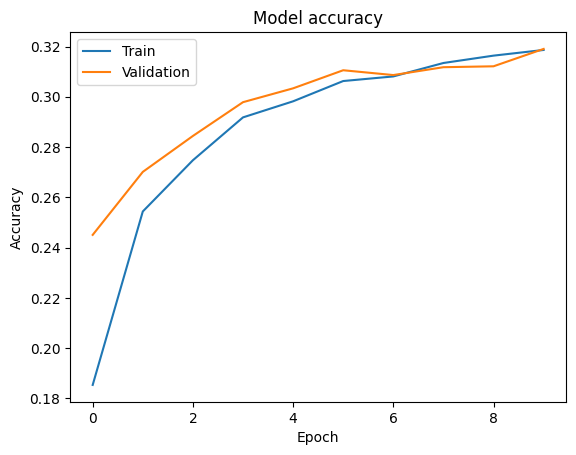

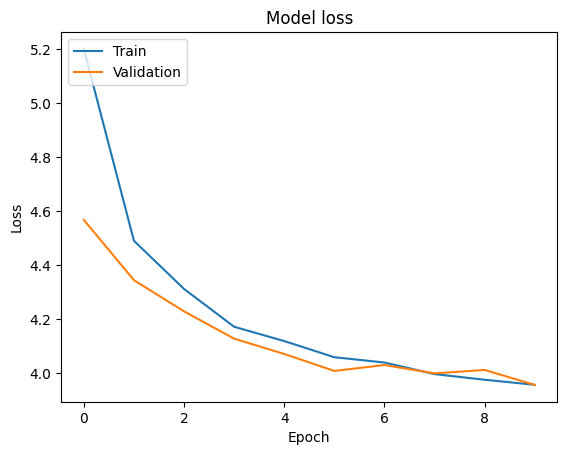

In [ ]:
plot_history(history_simple)

In [ ]:
def build_model(lstm_units=256, output_dim=128, dropout_rate=0.2, dense_units_output=128):
    context_input = Input(shape=(10,), dtype=tf.int32, name="context_input")
    context_embedding = Embedding(input_dim=context_tv.vocabulary_size(), output_dim=output_dim, mask_zero=False)(context_input)
    context_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
    context_lstm_out, context_state_h, context_state_c = context_lstm(context_embedding)
    context_lstm_out = Dropout(dropout_rate)(context_lstm_out)

    t9_input = Input(shape=(10,), dtype=tf.int32, name="t9_input")
    t9_embedding = Embedding(input_dim=input_t9_tv.vocabulary_size(), output_dim=output_dim, mask_zero=False)(t9_input)
    t9_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
    t9_lstm_out, t9_state_h, t9_state_c = t9_lstm(t9_embedding)
    t9_lstm_out = Dropout(dropout_rate)(t9_lstm_out)

    combined_state_h = Dense(lstm_units, activation='tanh')(Concatenate()([context_state_h, t9_state_h]))
    combined_state_c = Dense(lstm_units, activation='tanh')(Concatenate()([context_state_c, t9_state_c]))

    decoder_input = Input(shape=(10,), dtype=tf.int32, name="decoder_input")
    decoder_embedding = Embedding(input_dim=target_tv.vocabulary_size(), output_dim=output_dim, mask_zero=False)(decoder_input)
    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
    decoder_lstm_out, _, _ = decoder_lstm(decoder_embedding, initial_state=[combined_state_h, combined_state_c])
    decoder_lstm_out = Dropout(dropout_rate)(decoder_lstm_out)

    # Aligner les dimensions pour l'attention
    encoder_combined = Concatenate()([context_lstm_out, t9_lstm_out])  # (batch_size, 10, 2 * lstm_units)
    encoder_combined = Dense(lstm_units, activation='relu')(encoder_combined)  # Réduire à (batch_size, 10, lstm_units)
    attention = Attention()([decoder_lstm_out, encoder_combined])
    decoder_combined = Concatenate()([decoder_lstm_out, attention])

    dense = Dense(dense_units_output, activation='relu')(decoder_combined)
    dense = Dropout(dropout_rate)(dense)
    output = Dense(target_tv.vocabulary_size(), activation='softmax')(dense)

    model = Model(inputs=[context_input, t9_input, decoder_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], weighted_metrics=['sparse_categorical_accuracy'])
    return model

In [ ]:
# Visualiser le modèle
model = build_model()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

NameError: name 'context_tv' is not defined

In [ ]:
def build_hyper_model(hp):
    lstm_units = hp.Choice('lstm_units', [64, 128])  # Réduit de [64, 128, 256, 512]
    output_dim = hp.Choice('output_dim', [32, 64])   # Réduit de [32, 64, 128, 256]
    dropout_rate = hp.Float('dropout_rate', 0.0, 0.5, step=0.1)  # Limite à 0.5
    dense_units_output = hp.Choice('dense_units_output', [64, 128])
    return build_model(lstm_units, output_dim, dropout_rate, dense_units_output)

# Créer un objet tuner
tuner = keras_tuner.RandomSearch(
    build_hyper_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='chinese_news_tuning'
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)


# Réduire la taille des ensembles de données pour le tuning
ds_train_small = round(ds_train.cardinality().numpy()/6)
ds_val_small = round(ds_val.cardinality().numpy()/6)

tuner.search(
    ds_train_small,
    epochs=15,
    validation_data=ds_val_small,
    callbacks=[early_stopping]
)


# Obtenir le meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
model = build_model(
    lstm_units=best_hyperparameters.get('lstm_units'),
    output_dim=best_hyperparameters.get('output_dim'),
    dropout_rate=best_hyperparameters.get('dropout_rate'),
)


history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


2025-04-11 23:53:00.865058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:62: Filling up shuffle buffer (this may take a while): 46013 of 47017
2025-04-11 23:53:01.103735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


37613/37613 ━━━━━━━━━━━━━━━━━━━━ 3335s 88ms/step - accuracy: 0.1380 - loss: 5.8630 - sparse_categorical_accuracy: 0.1380 - val_accuracy: 0.2157 - val_loss: 5.2112 - val_sparse_categorical_accuracy: 0.2157
Epoch 2/50
37613/37613 ━━━━━━━━━━━━━━━━━━━━ 3326s 88ms/step - accuracy: 0.1570 - loss: 6.3890 - sparse_categorical_accuracy: 0.1570 - val_accuracy: 0.1875 - val_loss: 6.8404 - val_sparse_categorical_accuracy: 0.1875
Epoch 3/50
37613/37613 ━━━━━━━━━━━━━━━━━━━━ 3357s 89ms/step - accuracy: 0.1247 - loss: 8.6450 - sparse_categorical_accuracy: 0.1247 - val_accuracy: 0.2038 - val_loss: 8.1157 - val_sparse_categorical_accuracy: 0.2038
Epoch 4/50
37613/37613 ━━━━━━━━━━━━━━━━━━━━ 3396s 90ms/step - accuracy: 0.1013 - loss: 11.9733 - sparse_categorical_accuracy: 0.1013 - val_accuracy: 0.1292 - val_loss: 11.0328 - val_sparse_categorical_accuracy: 0.1292


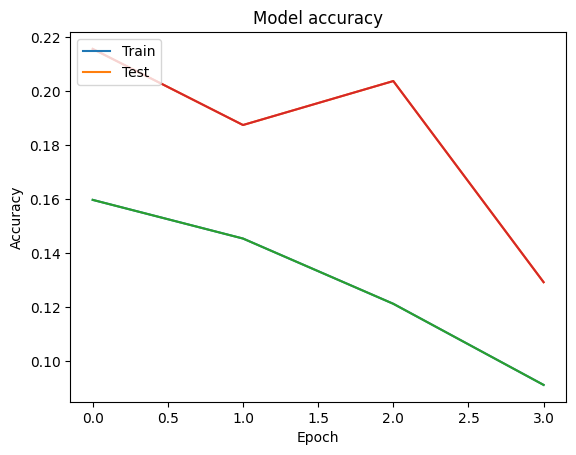

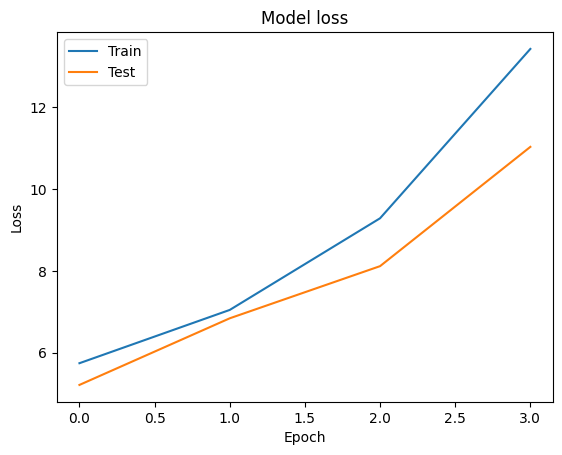

In [ ]:
plot_history(history)

In [ ]:
# Evaluer le modèle sur le jeu de test
test_loss, test_accuracy = model.evaluate(ds_test, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")

# Génération

In [ ]:
def generate_text(context, t9_sequence, max_length=50):
    # Vectoriser les entrées
    context_vector = context_tv([context])
    t9_vector = input_t9_tv([t9_sequence])
    
    # Initialiser la séquence générée
    generated = [target_tv.get_vocabulary().index("<START>")]
    output = []
    
    for _ in range(max_length):
        decoder_input = tf.constant([generated], dtype=tf.int32)
        pred = model.predict([context_vector, t9_vector, decoder_input], verbose=0)
        next_char_idx = tf.argmax(pred[0, -1, :]).numpy()
        next_char = target_tv.get_vocabulary()[next_char_idx]
        
        if next_char == "<END>":
            break
        
        output.append(next_char)
        generated.append(next_char_idx)
    
    return "".join(output)

# Exemple d'utilisation
context = "中国人民"
t9_input = "543 3264"  # Pour "jie fang"
result = generate_text(context, t9_input)
print(f"Contexte: {context}, T9: {t9_input} -> Résultat: {result}")